In [15]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import gudhi as gd  
import random as rd

In [16]:
networks={}
for name in ['PCD','CHR','DNA']:
    cName = 'Consensus '+name
    networks[name]=nx.read_edgelist('1 output\\'+name)
    networks[cName]=nx.read_edgelist('1 output\\'+cName)
    networks[name].name=name
    networks[cName].name=cName
    
[nx.info(G) for G in networks.values()]

["Graph named 'PCD' with 206 nodes and 2635 edges",
 "Graph named 'Consensus PCD' with 170 nodes and 1840 edges",
 "Graph named 'CHR' with 221 nodes and 2301 edges",
 "Graph named 'Consensus CHR' with 162 nodes and 1297 edges",
 "Graph named 'DNA' with 300 nodes and 6959 edges",
 "Graph named 'Consensus DNA' with 233 nodes and 4616 edges"]

# Networks Topology (original and consensus)

In [17]:
def persistantHomologyFromNetworkWithRips(G,name,dim,plot=True):      
    dm=pd.DataFrame(dict(nx.shortest_path_length(G))).sort_index()
    dm=dm[sorted(dm.columns)]
    skeleton = gd.RipsComplex(distance_matrix = dm.values) 

    Rips_simplex_tree = skeleton.create_simplex_tree(max_dimension = dim)
    
    BarCode = Rips_simplex_tree.persistence()
      
    #----Simplexes Resume
    simplexesLen={}
    for simplex,filtration in Rips_simplex_tree.get_filtration():
        if(len(simplex)-1 not in simplexesLen):
            simplexesLen[len(simplex)-1]=1
        else:
            simplexesLen[len(simplex)-1]+=1    

    simplexesResume=''
    for item in simplexesLen.items():
        simplexesResume+=str(item[0])+': '+str(item[1])+' | '
    simplexesResume[0:-3]  
    
    #----Barcode Resume
    
    dimensionsLen={}
    for dim in range(0,dim+1):
        dimensionsLen[dim]=len([bd for bd in BarCode if (bd[0]==dim)])

    dimensionResume=''
    for item in dimensionsLen.items():
        dimensionResume+=str(item[0])+': '+str(item[1])+' | '
    dimensionResume[0:-3]    
            
    #--Plot
    if plot:
        plt.figure(figsize=(10,10),dpi=250)
        gd.plot_persistence_barcode(BarCode,axes=plt.gca());    
        plt.title(name+'\n Simplexes: '+simplexesResume[0:-3]+'\n Numbers of Bars: '+dimensionResume[0:-3],fontsize=9)
        plt.tight_layout()
        plt.savefig('./2 output/Barcode - '+name+' - Rips.png',dpi=500,facecolor='white')
        plt.show()
    
    with open('2 output/'+name+'.pkl',mode='wb') as f:
        pickle.dump(BarCode,f)

usetex mode requires TeX.


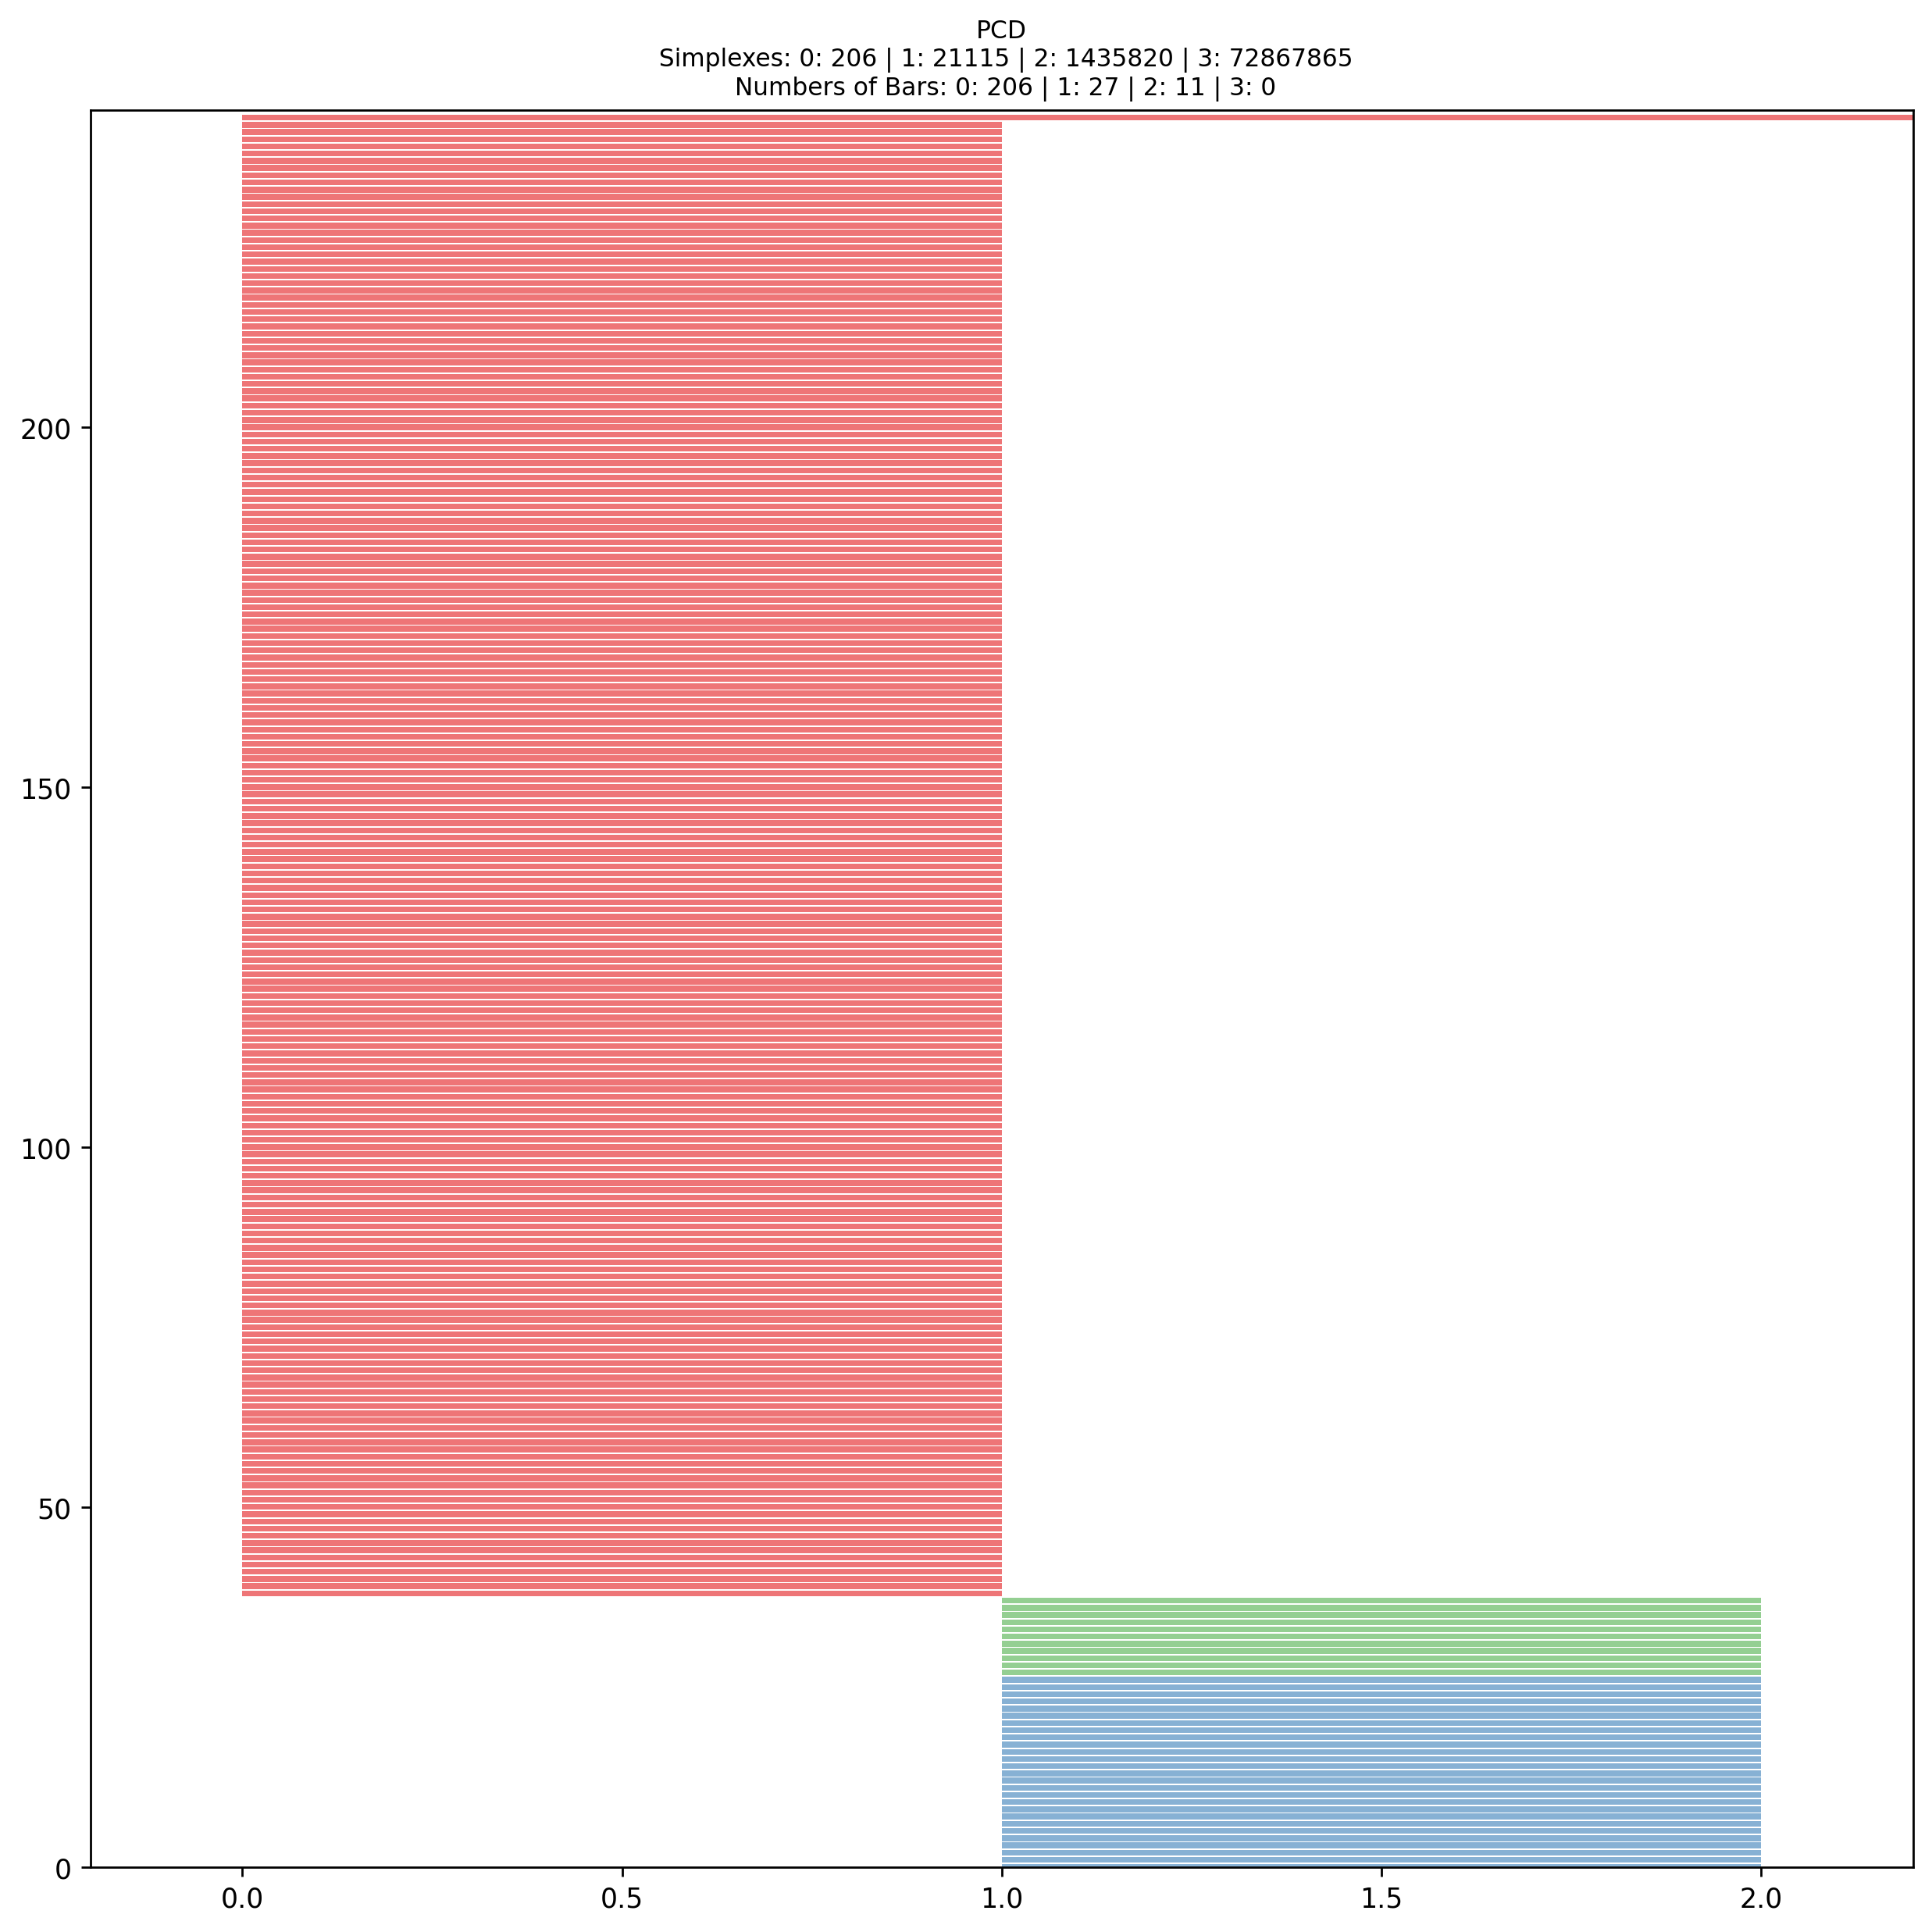

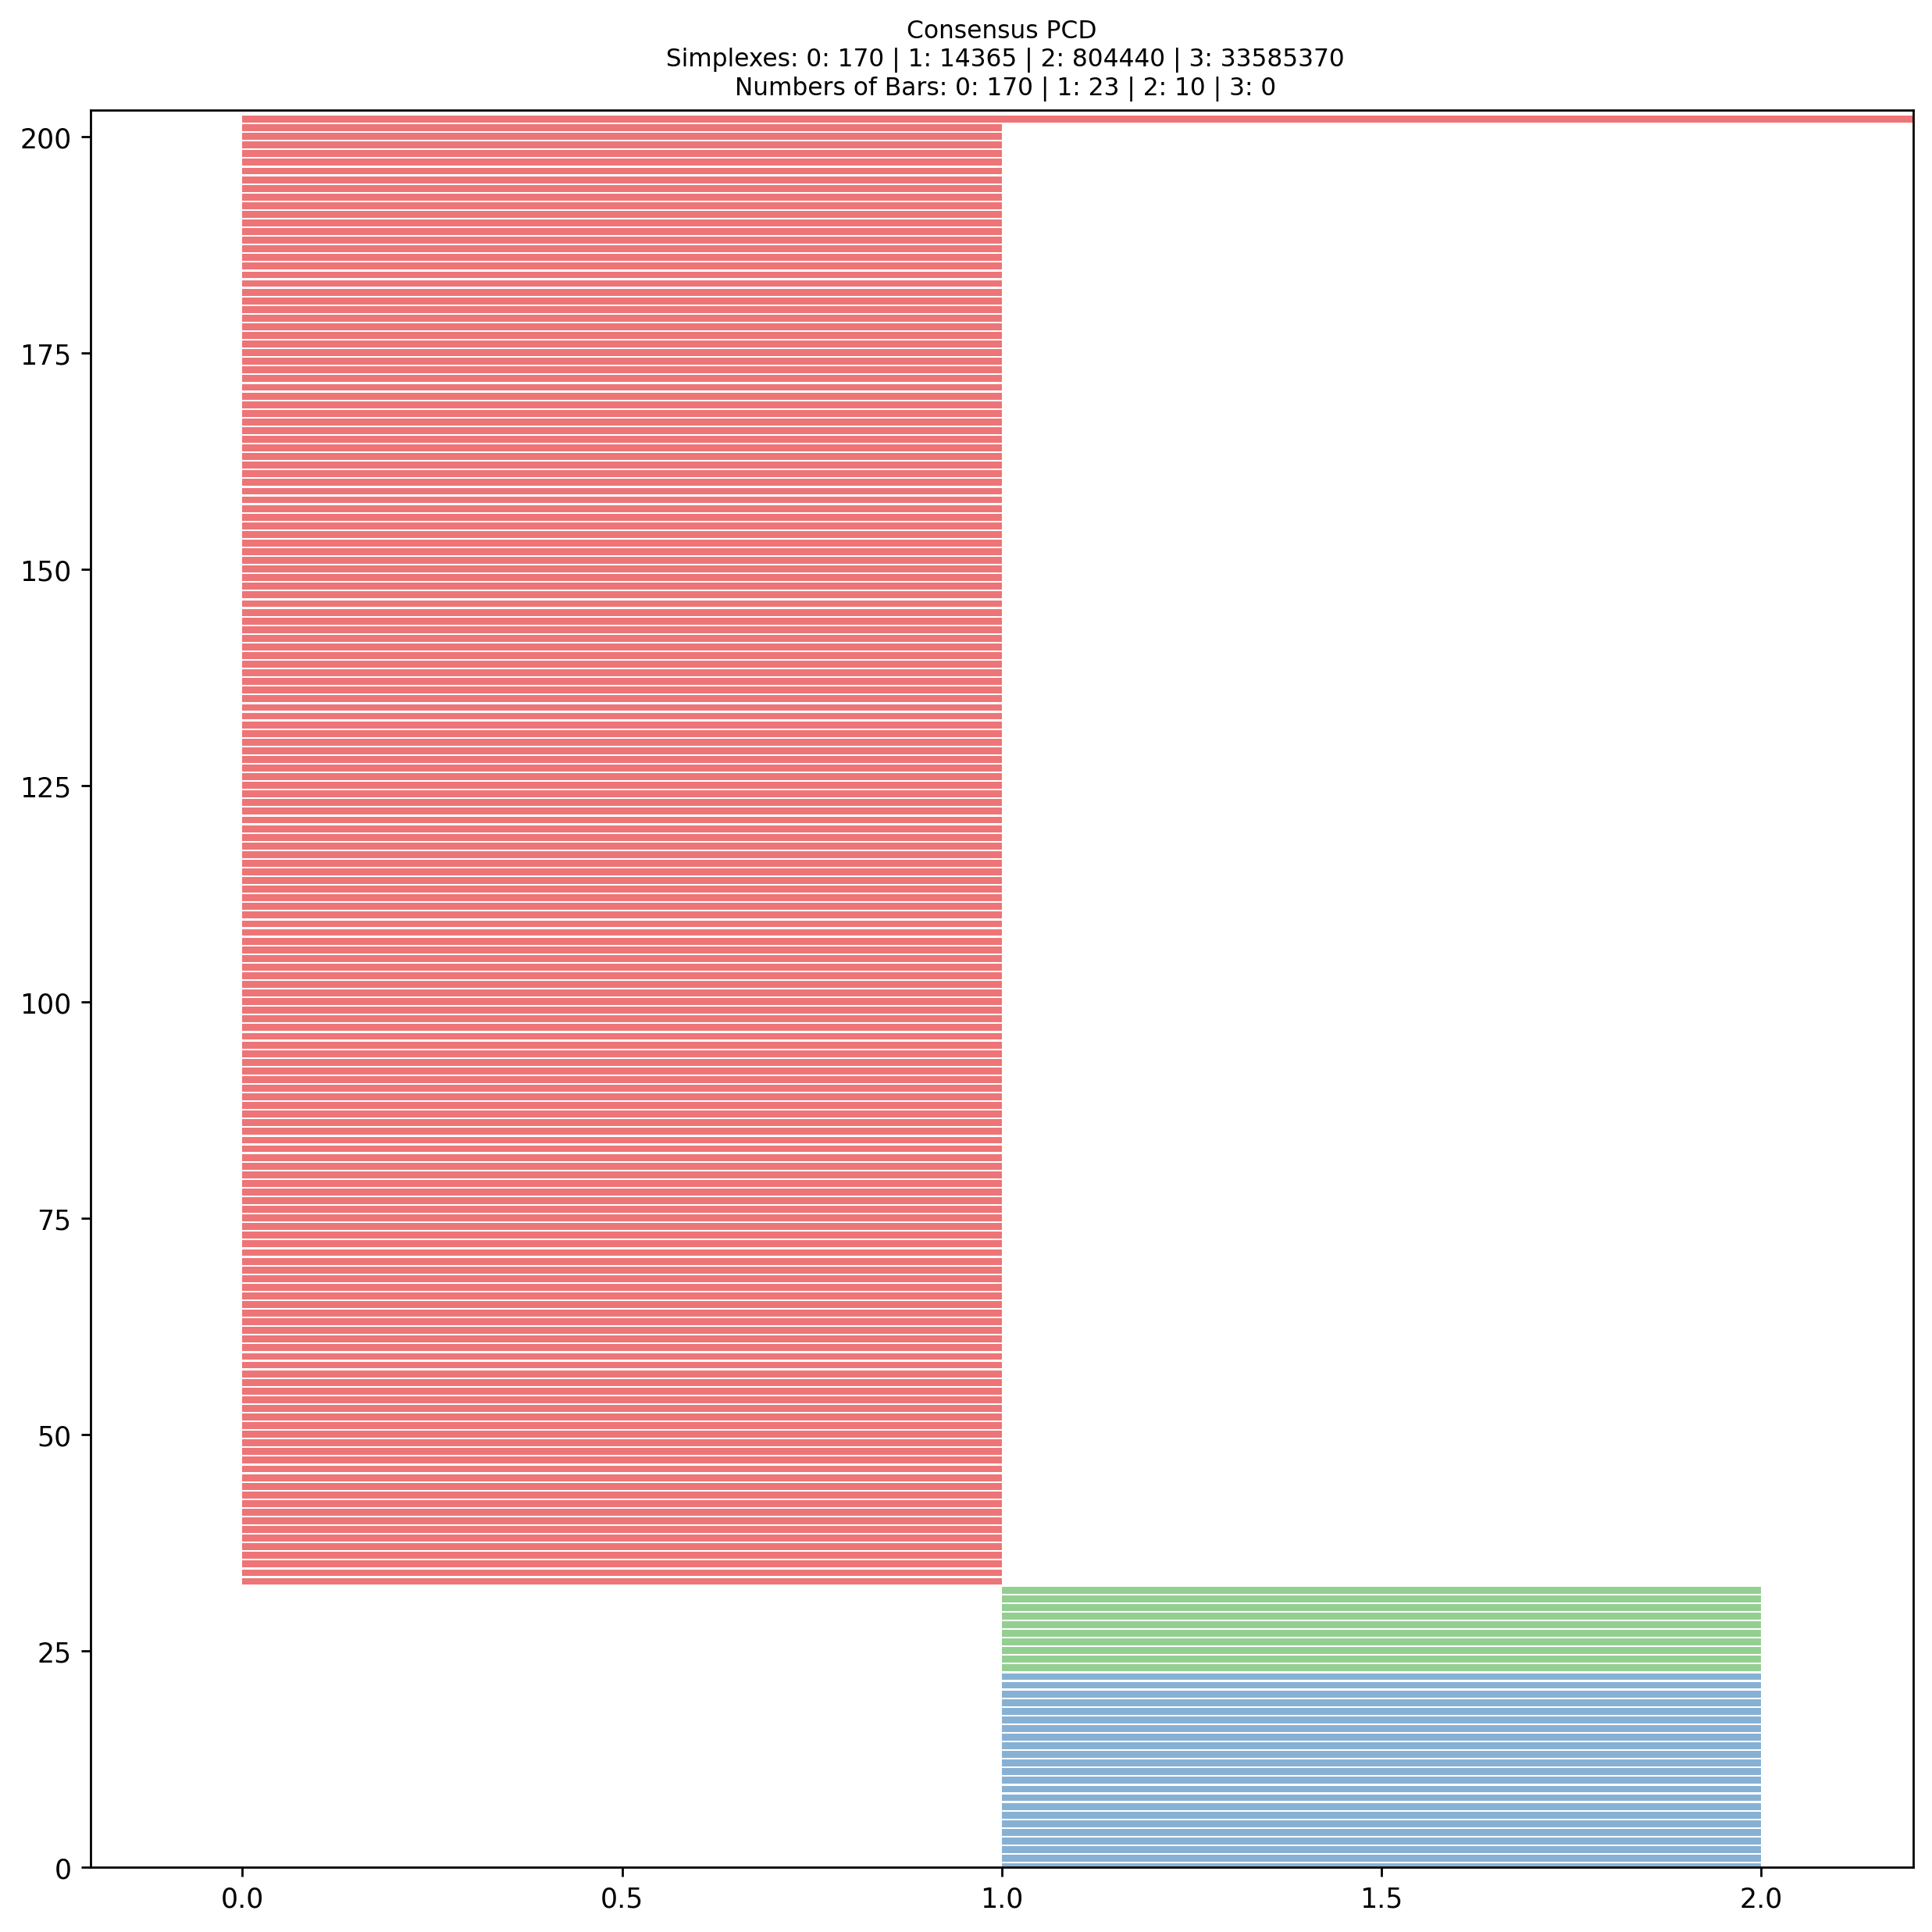

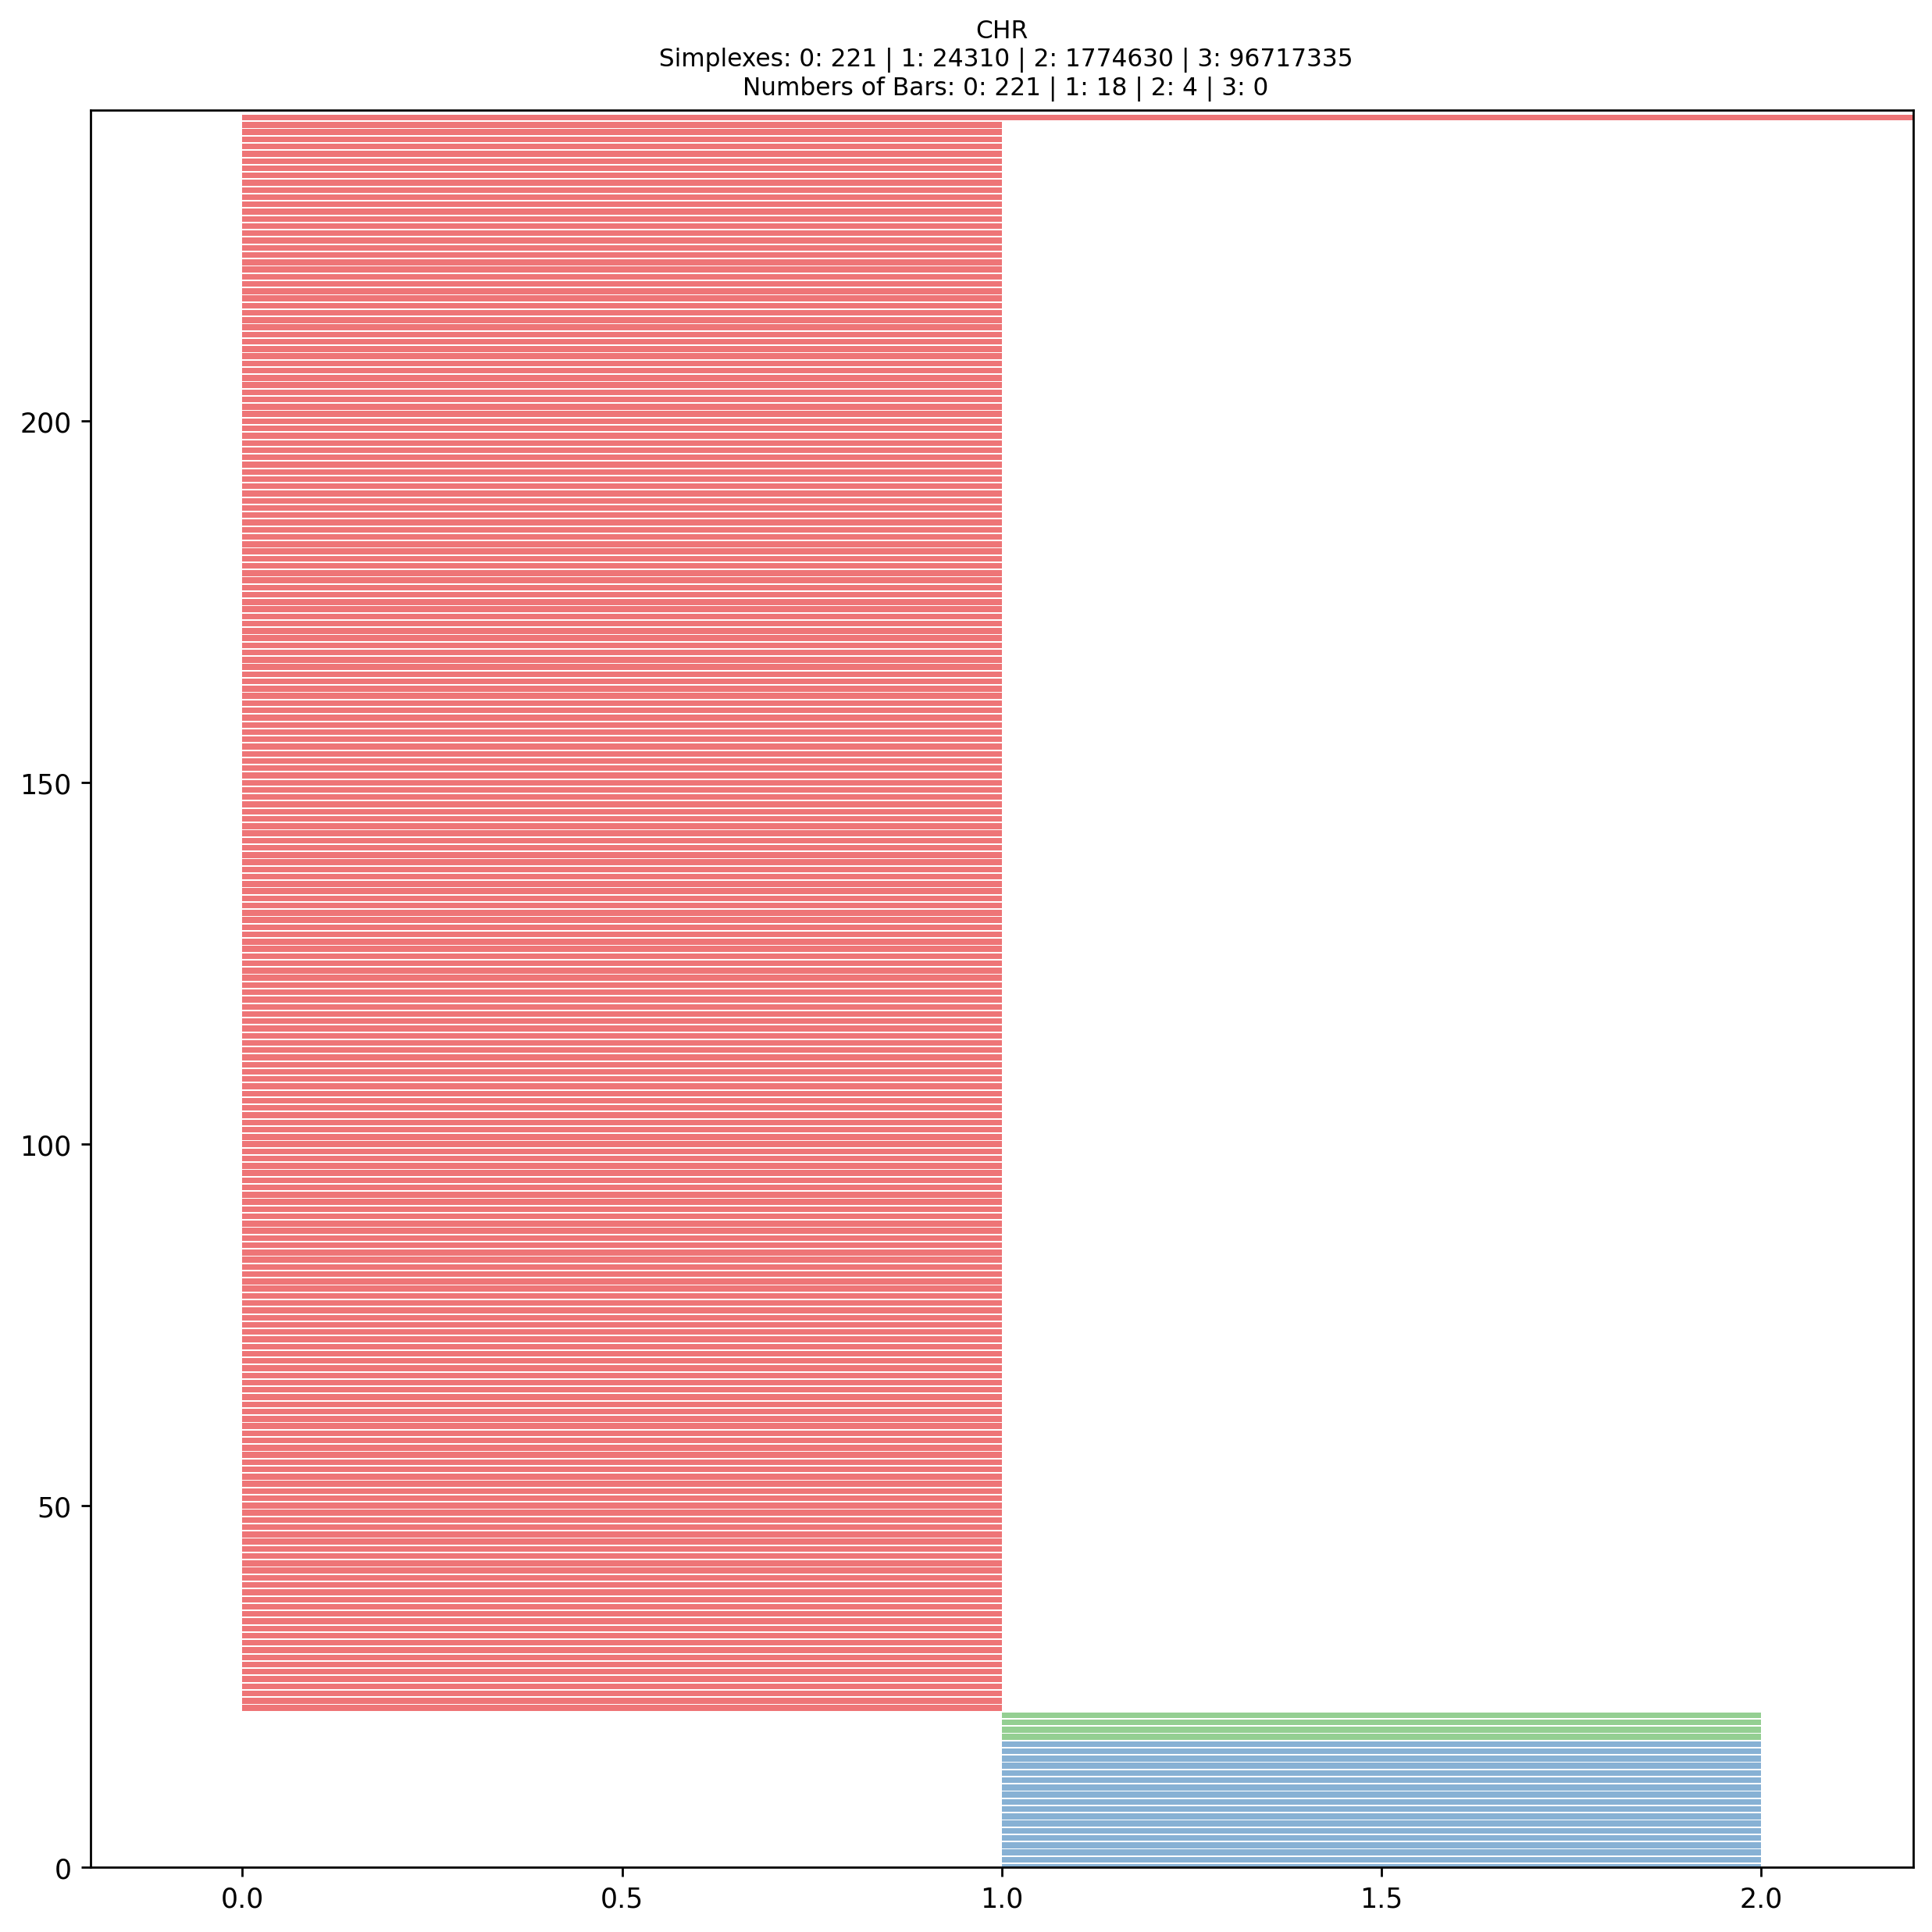

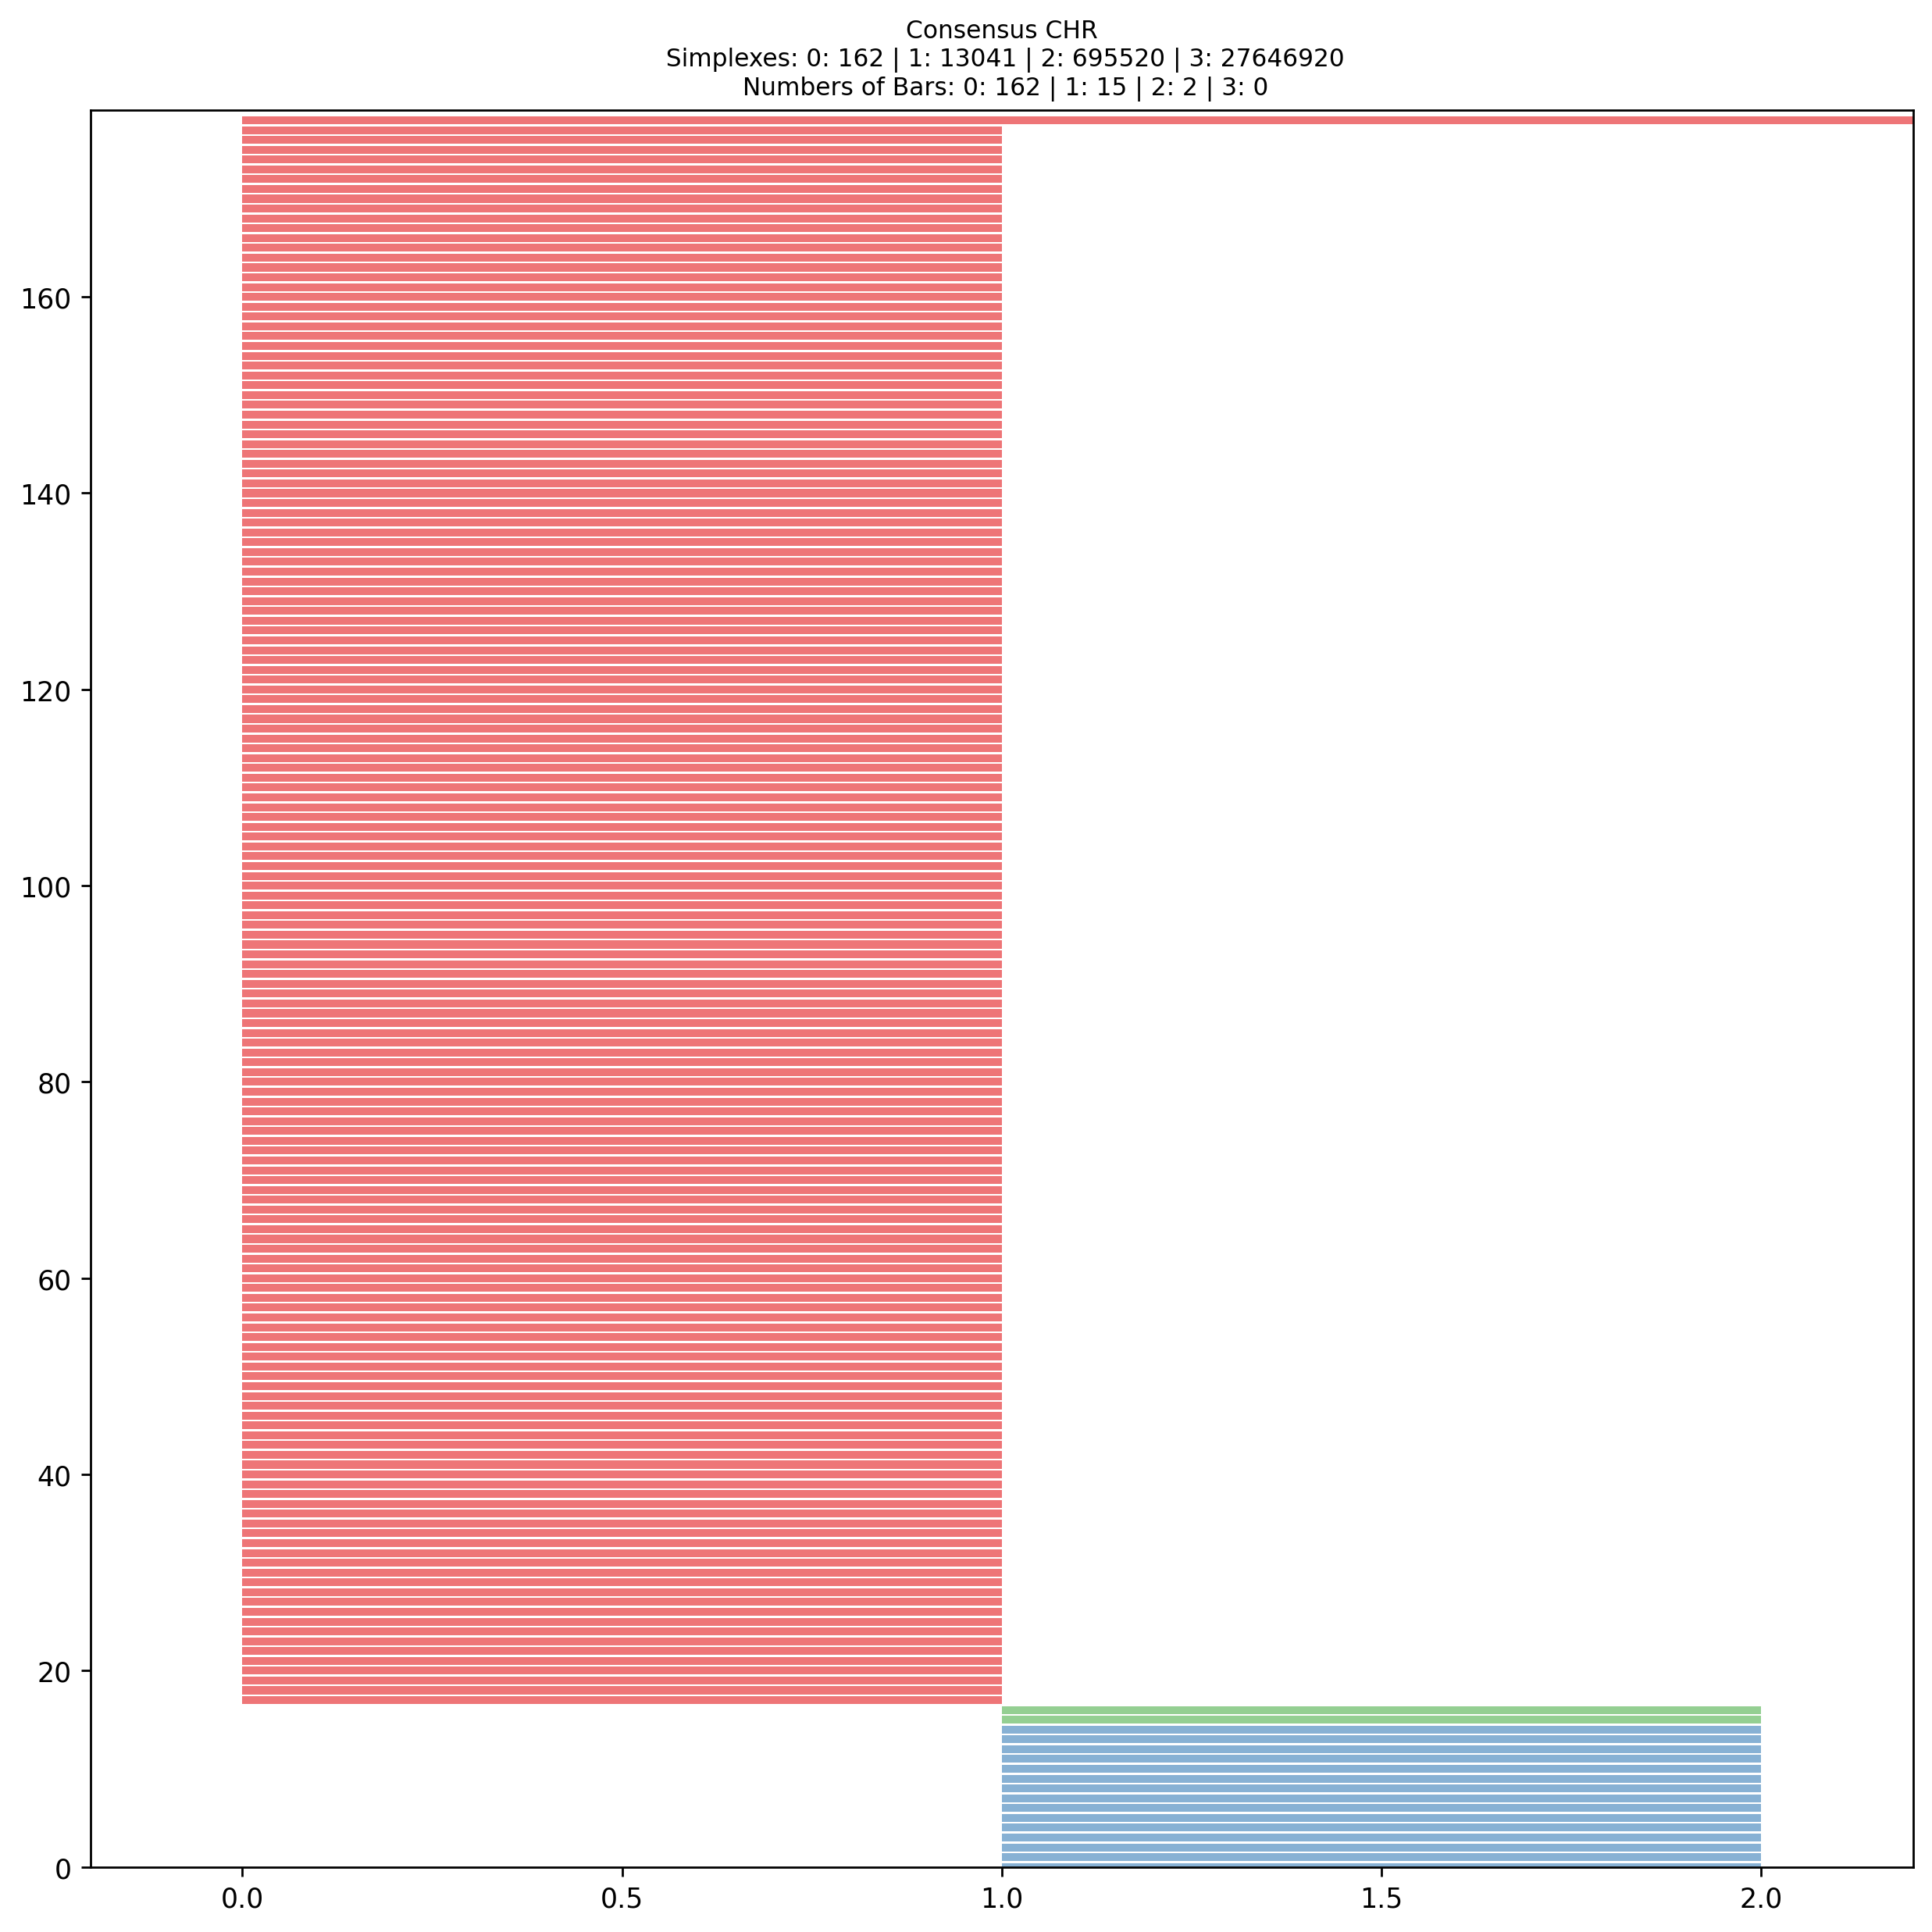

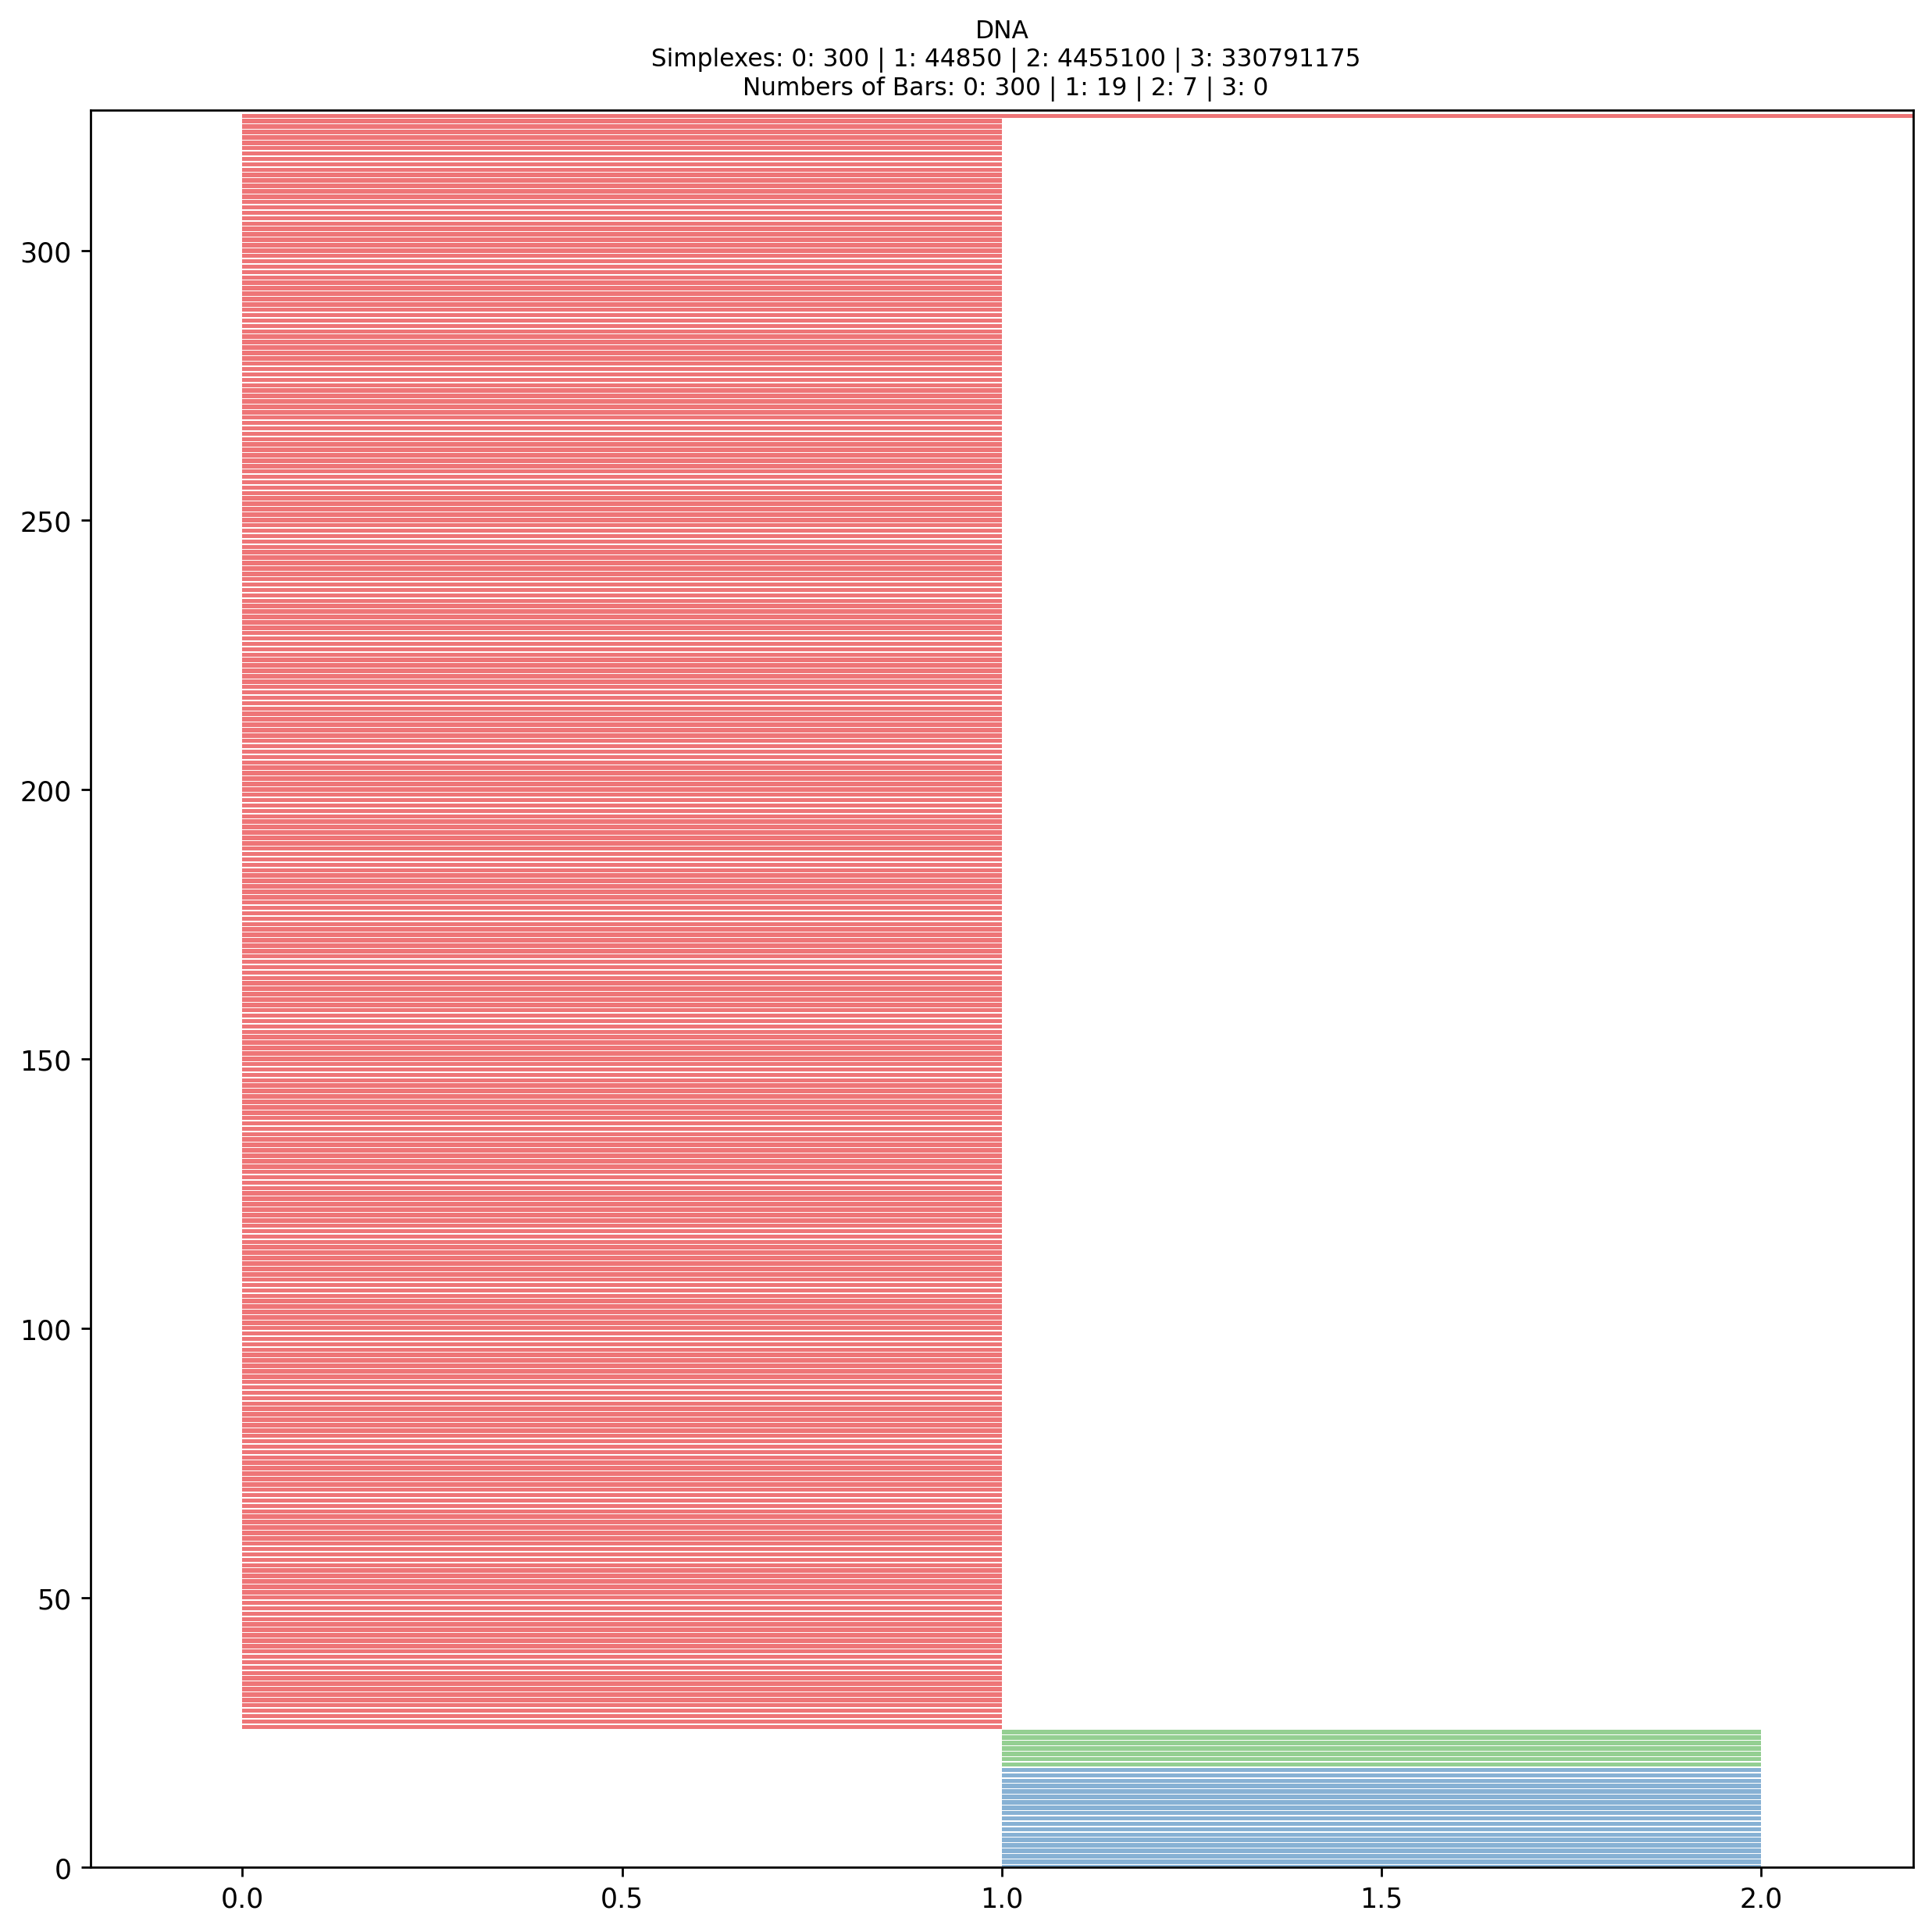

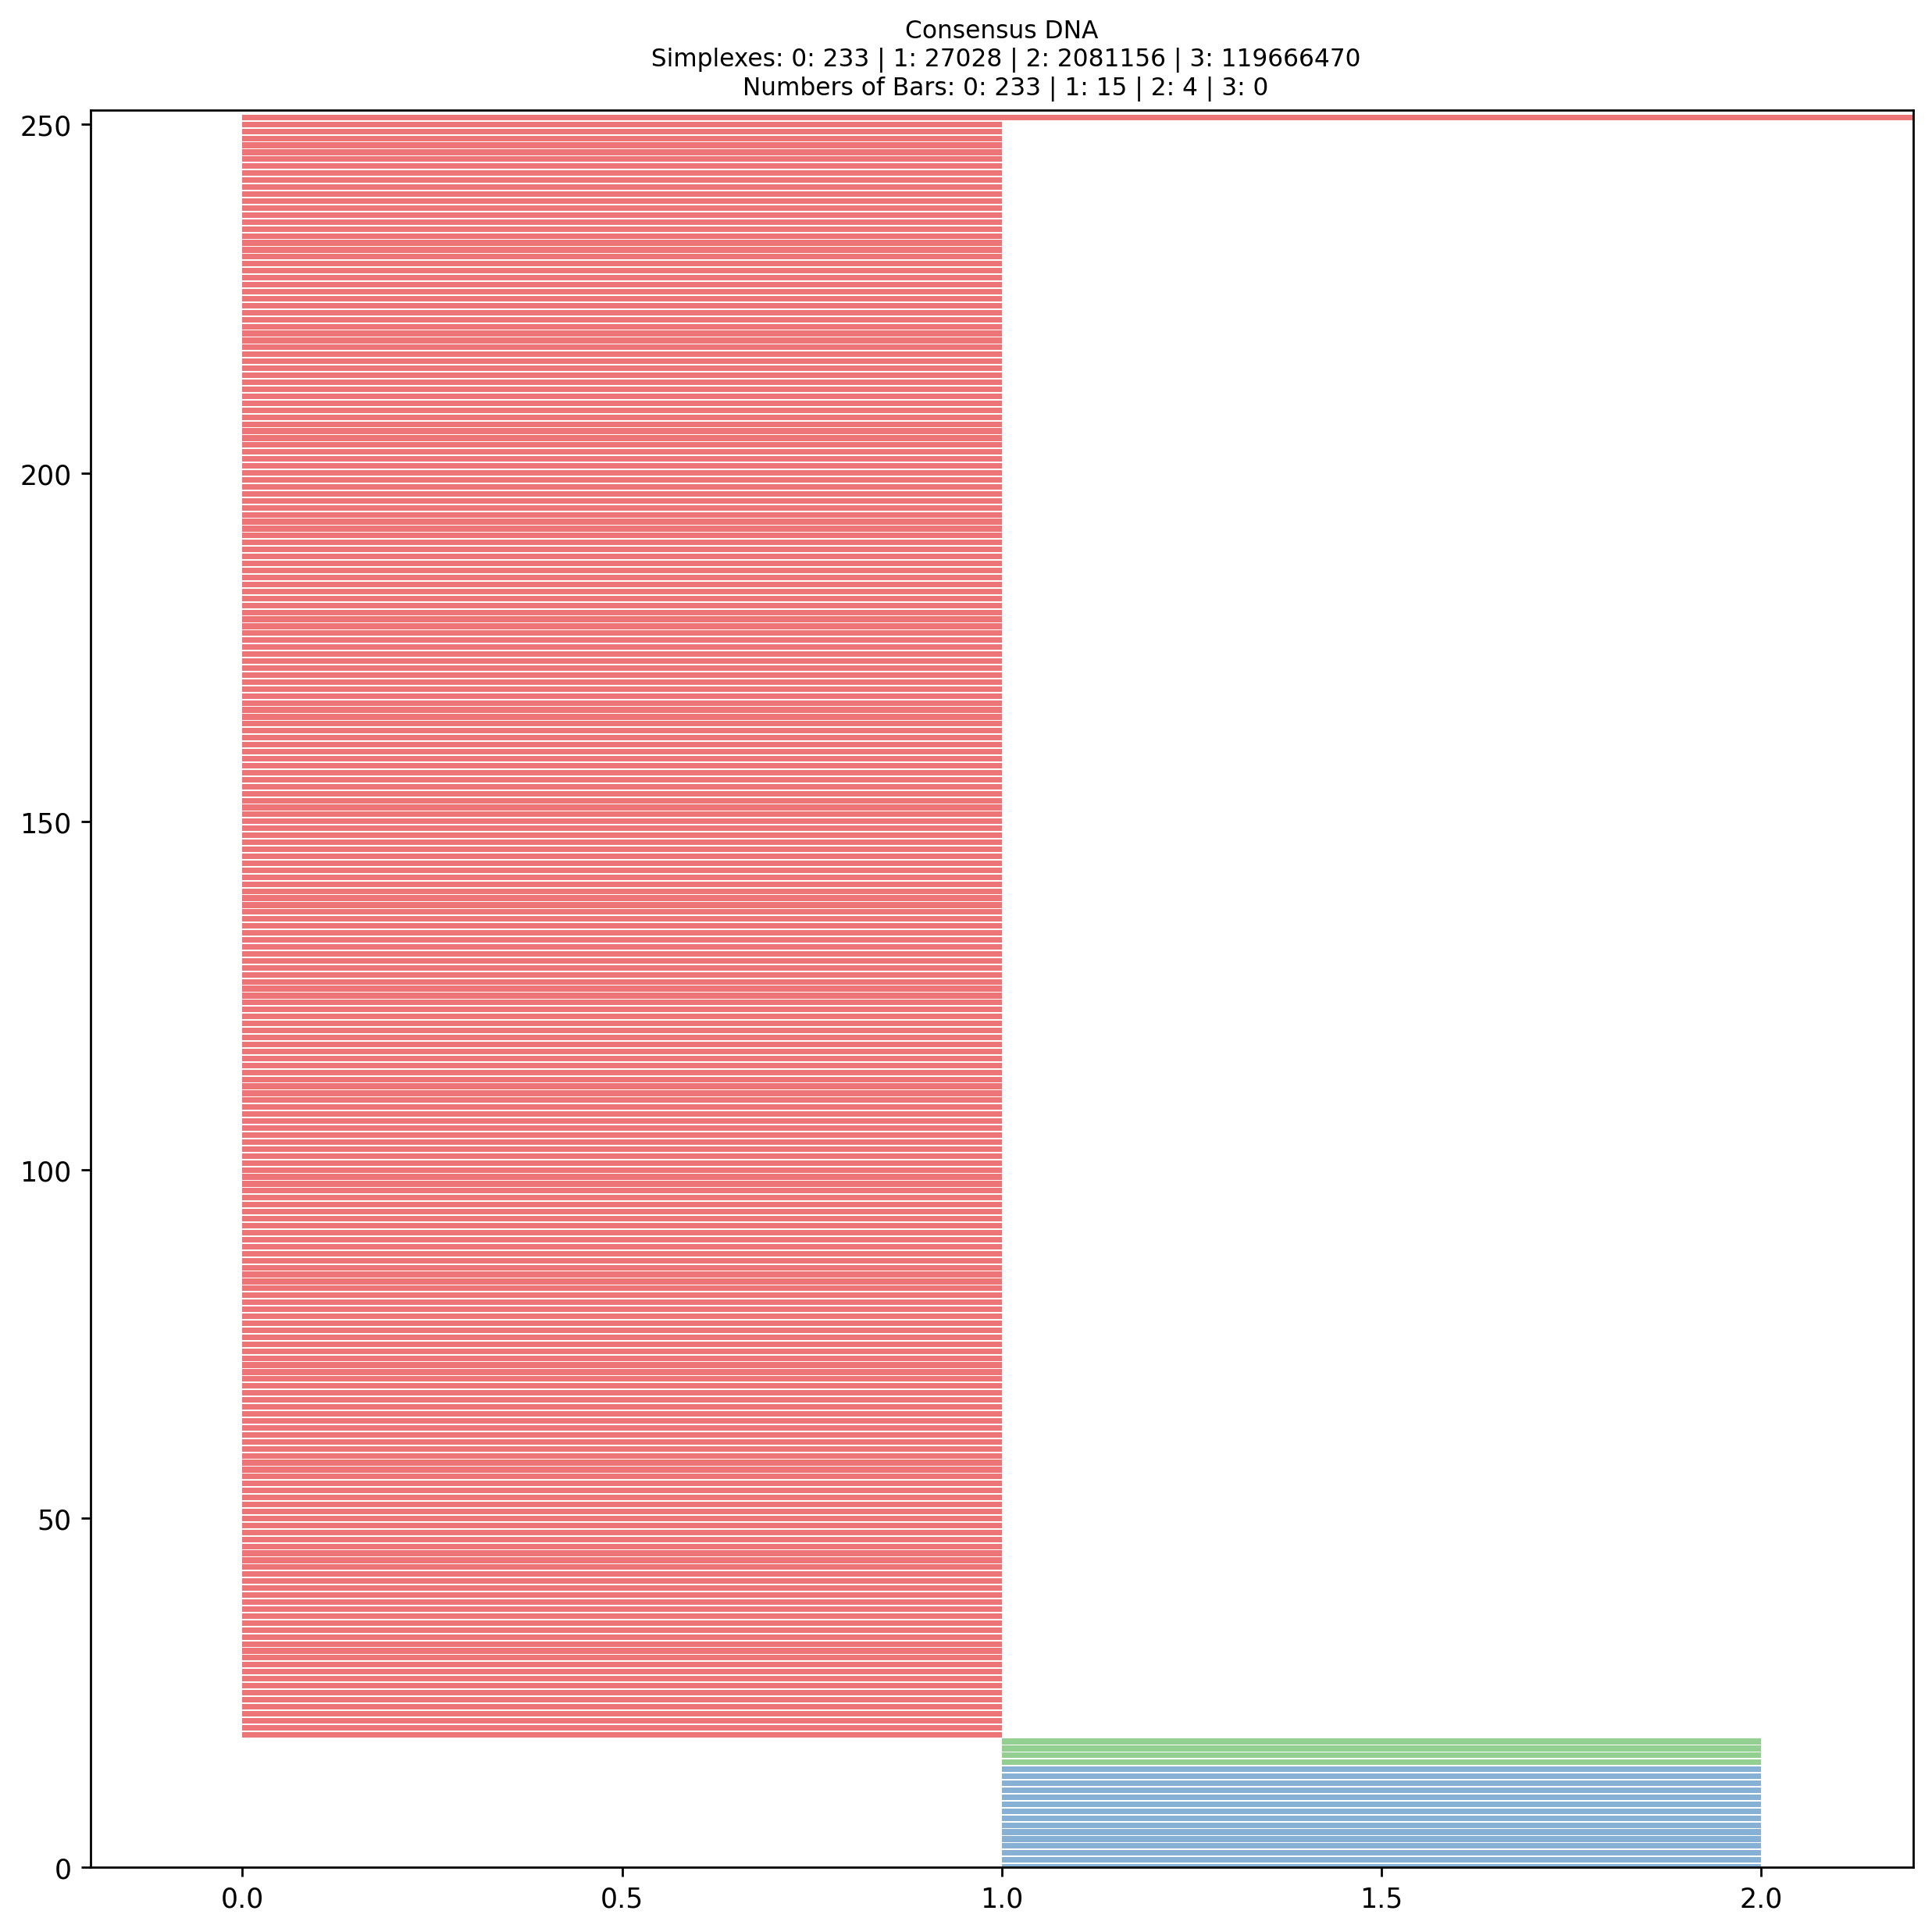

CPU times: total: 43min 22s
Wall time: 1h 13min 45s


In [11]:
%%time
for name,G in networks.items():
    persistantHomologyFromNetworkWithRips(G,name,3)

## Topology of Random Networks

#### Approach 1
Using an original network (PCD, CHR, DNA)  as a base, we extract an induced sub-graph from a random set. This set has the size of the respective consensus network. If the induced network has more than one connected component, a new random set is created.

In [52]:
randomNetworks={}
numberOfRandomNetworks=100
for sp in ['PCD','CHR','DNA']:
    randomNetworks[sp]=[]
    while len(randomNetworks[sp])<numberOfRandomNetworks:
        randomSetSize = networks['Consensus '+sp].number_of_nodes()
        original_G = networks[sp]
        originalGeneSet=list(original_G.nodes)

        #Create a random G
        rd.shuffle(originalGeneSet)
        random_G = nx.subgraph(original_G,originalGeneSet[:randomSetSize])
        ccs=nx.connected_components(random_G)
        #If it has more than one CC, create another
        while len(list(nx.connected_components(random_G))) != 1:
            rd.shuffle(originalGeneSet)
            random_G = nx.subgraph(original_G,originalGeneSet[:randomSetSize])
            ccs=nx.connected_components(random_G)
        randomNetworks[sp].append(random_G)

In [53]:
for sp in ['PCD','CHR','DNA']:
    print([(G.number_of_nodes(),G.number_of_edges()) for G in randomNetworks[sp]])

[(170, 1699), (170, 1733), (170, 1840), (170, 1825), (170, 1817), (170, 1737), (170, 1844), (170, 1901), (170, 1995), (170, 1703), (170, 1890), (170, 1806), (170, 1721), (170, 1903), (170, 1764), (170, 1651), (170, 1907), (170, 1856), (170, 1883), (170, 1792), (170, 2029), (170, 2066), (170, 1723), (170, 1796), (170, 1899), (170, 1886), (170, 1872), (170, 1935), (170, 1742), (170, 1740), (170, 1737), (170, 1939), (170, 1876), (170, 1935), (170, 1925), (170, 1784), (170, 1913), (170, 1794), (170, 1902), (170, 1868), (170, 1784), (170, 1880), (170, 1887), (170, 1746), (170, 1873), (170, 1774), (170, 1545), (170, 1886), (170, 1844), (170, 1851), (170, 1835), (170, 1852), (170, 1636), (170, 1700), (170, 1675), (170, 1953), (170, 1746), (170, 1784), (170, 1795), (170, 1607), (170, 1650), (170, 1750), (170, 1850), (170, 1836), (170, 1800), (170, 1730), (170, 1854), (170, 1569), (170, 1721), (170, 1663), (170, 1697), (170, 1707), (170, 1858), (170, 1775), (170, 1825), (170, 1972), (170, 1613)

In [54]:
for sp in ['PCD','CHR','DNA']:
    for i,G in enumerate(randomNetworks[sp]):
        name=sp+' Random '+str(i)
        persistantHomologyFromNetworkWithRips(G,name,2,plot=False)

#### Approach 2
This approach is similar to the first one, but instead of choosing a random set and checking if it creates one connected component, we randomly choose a node and start a random walk until we reach the number of nodes desired. After that, we extract the induced subnetwork.

In [4]:
def randomWalkUniqueSetOfNodes(G,startNode,setLen):
    uniqueSet=set()
    actualNode=startNode
    uniqueSet.add(actualNode)

    while len(uniqueSet)<setLen:
        n=list(G.neighbors(actualNode))
        actualNode=np.random.choice(n)
        uniqueSet.add(actualNode)

    return uniqueSet

In [12]:
randomNetworks={}
numberOfRandomNetworks=90
for sp in ['PCD','CHR','DNA']:
    randomNetworks[sp]=[]
    while len(randomNetworks[sp])<numberOfRandomNetworks:
        randomSetSize = networks['Consensus '+sp].number_of_nodes()
        original_G = networks[sp]
        originalGeneSet=list(original_G.nodes)
        startNode=np.random.choice(originalGeneSet)
        randomSet=randomWalkUniqueSetOfNodes(original_G,startNode,randomSetSize)
        random_G = nx.subgraph(original_G,randomSet)
        randomNetworks[sp].append(random_G)

In [13]:
for sp in ['PCD','CHR','DNA']:
    print([(G.number_of_nodes(),G.number_of_edges()) for G in randomNetworks[sp]])

[(170, 2507), (170, 2537), (170, 2507), (170, 2513), (170, 2518), (170, 2488), (170, 2515), (170, 2524), (170, 2510), (170, 2495), (170, 2503), (170, 2511), (170, 2476), (170, 2482), (170, 2477), (170, 2453), (170, 2540), (170, 2513), (170, 2501), (170, 2502), (170, 2501), (170, 2514), (170, 2439), (170, 2521), (170, 2535), (170, 2478), (170, 2514), (170, 2483), (170, 2510), (170, 2492), (170, 2514), (170, 2499), (170, 2486), (170, 2491), (170, 2515), (170, 2456), (170, 2522), (170, 2509), (170, 2481), (170, 2494), (170, 2464), (170, 2518), (170, 2485), (170, 2483), (170, 2483), (170, 2514), (170, 2498), (170, 2526), (170, 2495), (170, 2425), (170, 2520), (170, 2534), (170, 2519), (170, 2487), (170, 2494), (170, 2513), (170, 2526), (170, 2483), (170, 2515), (170, 2508), (170, 2507), (170, 2505), (170, 2526), (170, 2506), (170, 2527), (170, 2515), (170, 2522), (170, 2517), (170, 2508), (170, 2484), (170, 2507), (170, 2480), (170, 2495), (170, 2486), (170, 2499), (170, 2525), (170, 2487)

In [14]:
%%time
for sp in ['PCD','CHR','DNA']:
    for i,G in enumerate(randomNetworks[sp]):
        name=sp+' Random '+str(i+10)
        persistantHomologyFromNetworkWithRips(G,name,3,plot=False)

CPU times: total: 14h 44min 36s
Wall time: 14h 44min 56s


In [ ]:
15 min para 10 PCD | 150 = 2h30
12 min para 10 CHR | 120 = 2h
58 min para 10 DNA | 580 = 6h